# Covid 19 Identification with Chest X Ray


Created By Lalith Kahatapitiya at [PGIS](http://www.pgis.pdn.ac.lk/) - University of Peradeniya

# Data set Credit :
1. [Balanced Augmented Covid CXR Datase](https://www.kaggle.com/datasets/tr1gg3rtrash/balanced-augmented-covid-cxr-dataset) by [MRINAL TYAGI](https://www.kaggle.com/tr1gg3rtrash).

2. [KyleNet Experimental COVID-19 Dataset](https://www.kaggle.com/datasets/kylemcpherson/kylenet-experimental-dataset) by [Kalzeo](https://www.kaggle.com/kylemcpherson).


# This is the result from each version run on the Kaggle.

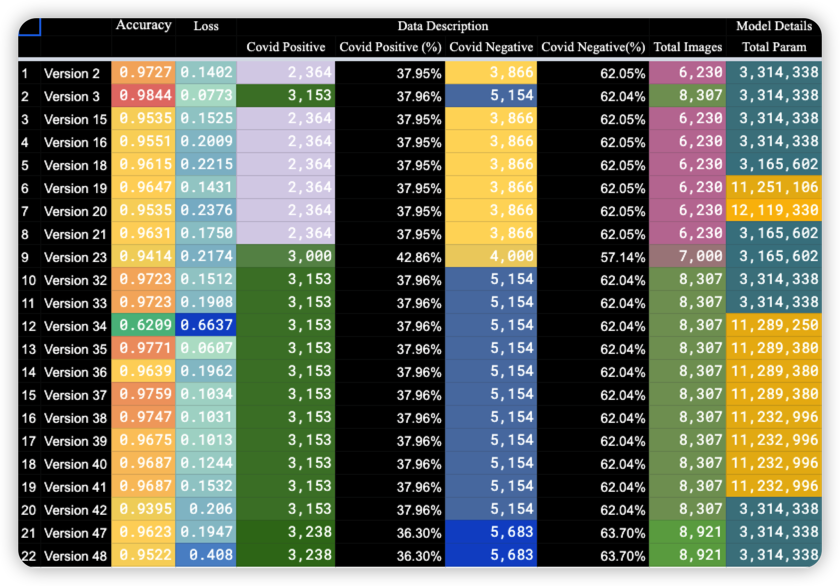


[Datasheet](https://docs.google.com/spreadsheets/d/1wtD3Gx3iLCJO_bs5j1wgDMO9EsDAjMM1aXyK1AUhnHY/edit?usp=sharing)

# System Parameter show




In [1]:
import sys
import platform
import os
import datetime
import pytz
timezone = pytz.timezone("Asia/Colombo")
import random

import shutil

import tensorflow.keras
import tensorflow as tf
import pandas as pd
import sklearn as sk
import numpy as np
import cv2
from matplotlib import pyplot as plt
import seaborn as sns

from tqdm import tqdm

print(f"Python Platform: {platform.platform()}")
print(f"Python {sys.version}")
print()
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"Numpy {np.__version__}")
print(f"Open CV {cv2.__version__}")
print()
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")


# def working_dir_clean():
#     list_all_file=os.listdir("./")
#     for file_name in list_all_file:
#         try:
#             shutil.rmtree("./"+file_name)
#             print(f"Remove File Name : {file_name}")
        
#         except Exception as e:
#             print('Exception:',e)
#                     #if any exception rasied, the exception will be printed here. And pass to the next image
        
# working_dir_clean()

Python Platform: macOS-12.6-arm64-arm-64bit
Python 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:00:33) 
[Clang 13.0.1 ]

Tensor Flow Version: 2.10.0
Keras Version: 2.10.0
Pandas 1.5.0
Scikit-Learn 1.1.2
Numpy 1.23.2
Open CV 4.6.0

GPU is available


# Data Set Location Verified and Find Image's Folder

In [2]:
# image data set_path mapping check folder names
dataset_path = 'TRAINING'
# categories = os.listdir(dataset_path)
# print(categories)

# Data Labels creation

In [3]:
categories_all = os.listdir(dataset_path)
categories = []
for category in categories_all:
    if (category == ".DS_Store"):
        continue
    else:
        categories.append(category)

labels = [i for i in range(len(categories))]

label_dict = dict(zip(categories, labels))  # empty dictionary


print(label_dict)
print(categories)
print(labels)

{'NORMAL': 0, 'COVID': 1}
['NORMAL', 'COVID']
[0, 1]


# Images count in each folder

In [4]:
# "COVID-19"
folder_path_covid =[
    "TRAINING/COVID",
]


img_path_covid_old =[]
for folder_path in folder_path_covid:
    img_names=os.listdir(folder_path)
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img_path_covid_old.append(img_path)
        


# "NON-COVID"
folder_path_non_covid =[
"TRAINING/NORMAL",
]



img_path_non_covid_old =[]
for folder_path in folder_path_non_covid:
    img_names=os.listdir(folder_path)
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img_path_non_covid_old.append(img_path)

        # images array shuffles
img_path_covid_old = random.sample(img_path_covid_old, len(img_path_covid_old))
img_path_non_covid_old = random.sample(img_path_non_covid_old, len(img_path_non_covid_old))
 
total_ca_images = len(img_path_covid_old) + len(img_path_non_covid_old)

print(f"Containe Covid images count     : {len(img_path_covid_old)}")           
print(f"Non covid images count : {len(img_path_non_covid_old)}")   
print(f"All images count       : {total_ca_images}")     
        
#  images array lenth 
# divider = 15
# middle_img_path_covid = int(len(img_path_covid_old)/divider)
# middle_img_path_non_covid = int(len(img_path_non_covid_old)/divider)

middle_img_path_covid = 15
middle_img_path_non_covid = 15

img_path_covid =img_path_covid_old[:middle_img_path_covid]
img_path_non_covid =img_path_non_covid_old[:middle_img_path_non_covid]

total_images = len(img_path_non_covid) + len(img_path_covid)

print(f"Covid images count     : {len(img_path_covid)}")           
print(f"Non covid images count : {len(img_path_non_covid)}")   
print(f"All images count       : {total_images}") 
print(f"Covid images           : {round((len(img_path_covid)/total_images)*100, 2)} %")           
print(f"Non covid images       : {round((len(img_path_non_covid)/total_images)*100, 2)} %")  

Containe Covid images count     : 4099
Non covid images count : 5361
All images count       : 9460
Covid images count     : 15
Non covid images count : 15
All images count       : 30
Covid images           : 50.0 %
Non covid images       : 50.0 %


# Read selected images to array

In [5]:
start_time = datetime.datetime.now(tz=timezone)
print(f"Start images reading :{start_time}")
img_size = 224
data = []
target = []
covid = []
normal = []


def image_read(img_path):
    img = cv2.imread(img_path)
    try:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Coverting the image into gray scale
        resized = cv2.resize(gray, (img_size, img_size))
        # resizing the gray scale into 224x224, since we need a fixed common size for all the images in the dataset
        return True, resized

    except Exception as e:

        # if any exception rasied, the exception will be return here. And pass to the next image
        return False, e


for img_path in img_path_covid:
    success, resized = image_read(img_path)
    if (success == False):
        print("non covid images error")
    else:
        covid.append(resized)
        target.append(label_dict["COVID"])


for img_path in img_path_non_covid:
    success, resized = image_read(img_path)
    if (success == False):
        print("covid images error")
    else:
        normal.append(resized)
        target.append(label_dict["NORMAL"])


data = covid + normal
end_time = datetime.datetime.now(tz=timezone)
print(f"End images reading :{end_time}")

print(f"Total time taken {end_time-start_time}")


Start images reading :2022-10-25 15:45:53.573024+05:30
End images reading :2022-10-25 15:45:53.862674+05:30
Total time taken 0:00:00.289650


# Normal Chest X-Ray Images

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 338.87it/s]


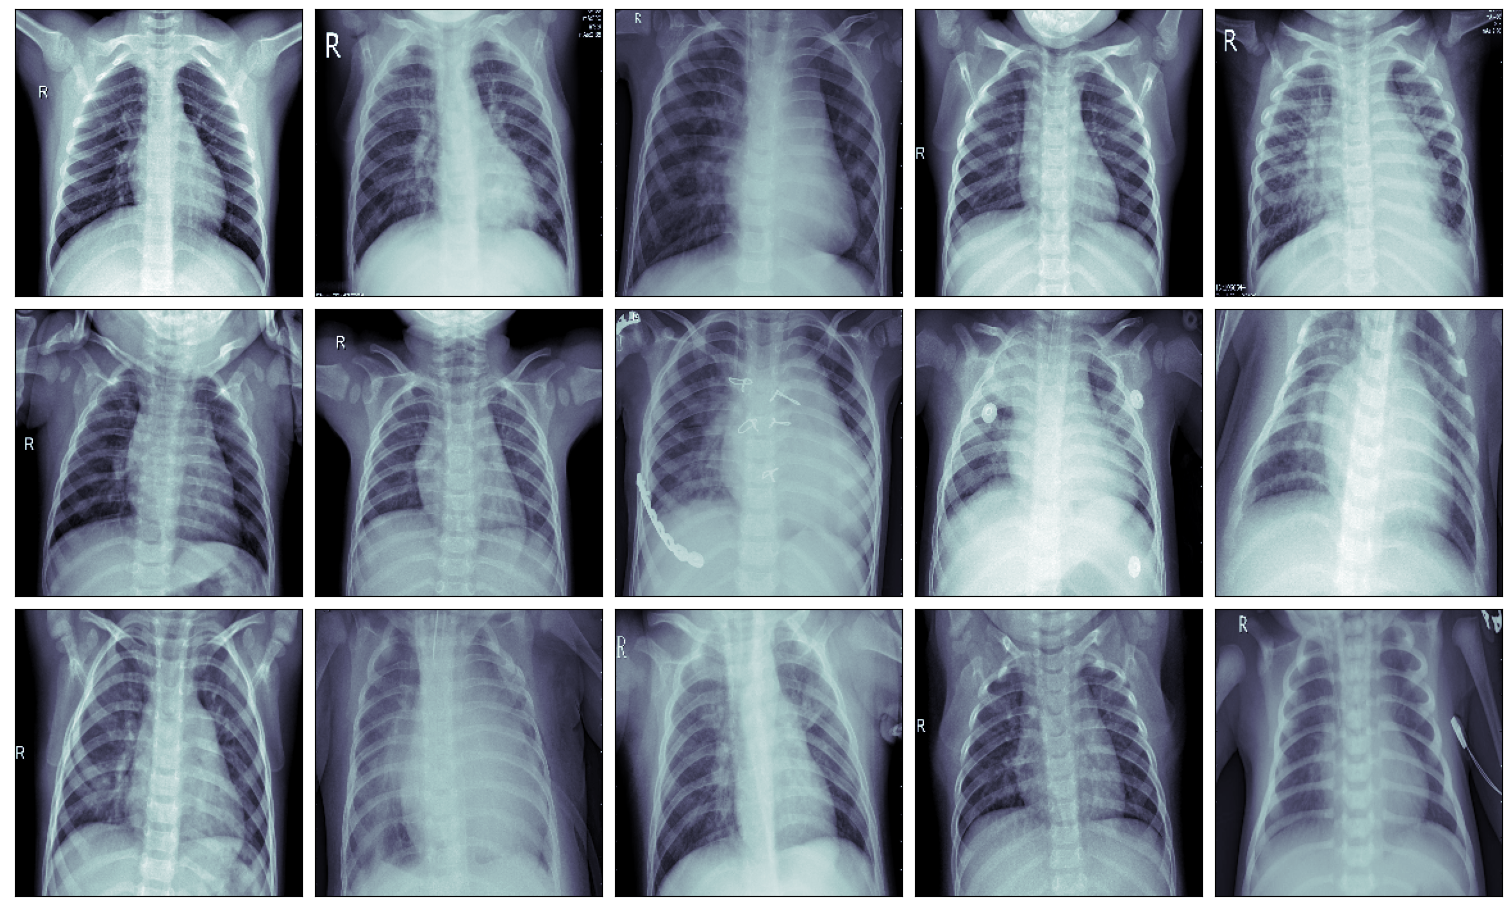

In [6]:
n_row = 3
n_col = 5

fig, ax = plt.subplots(n_row, n_col, figsize = (n_col*3, n_row*3), constrained_layout = True)

for row in tqdm(range(n_row)):
    
    for col in range(n_col):
        ax[row][col].imshow(normal[row*n_col + col], cmap = 'bone')
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])

# Covid Positive Chest X-Ray Images

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 481.94it/s]


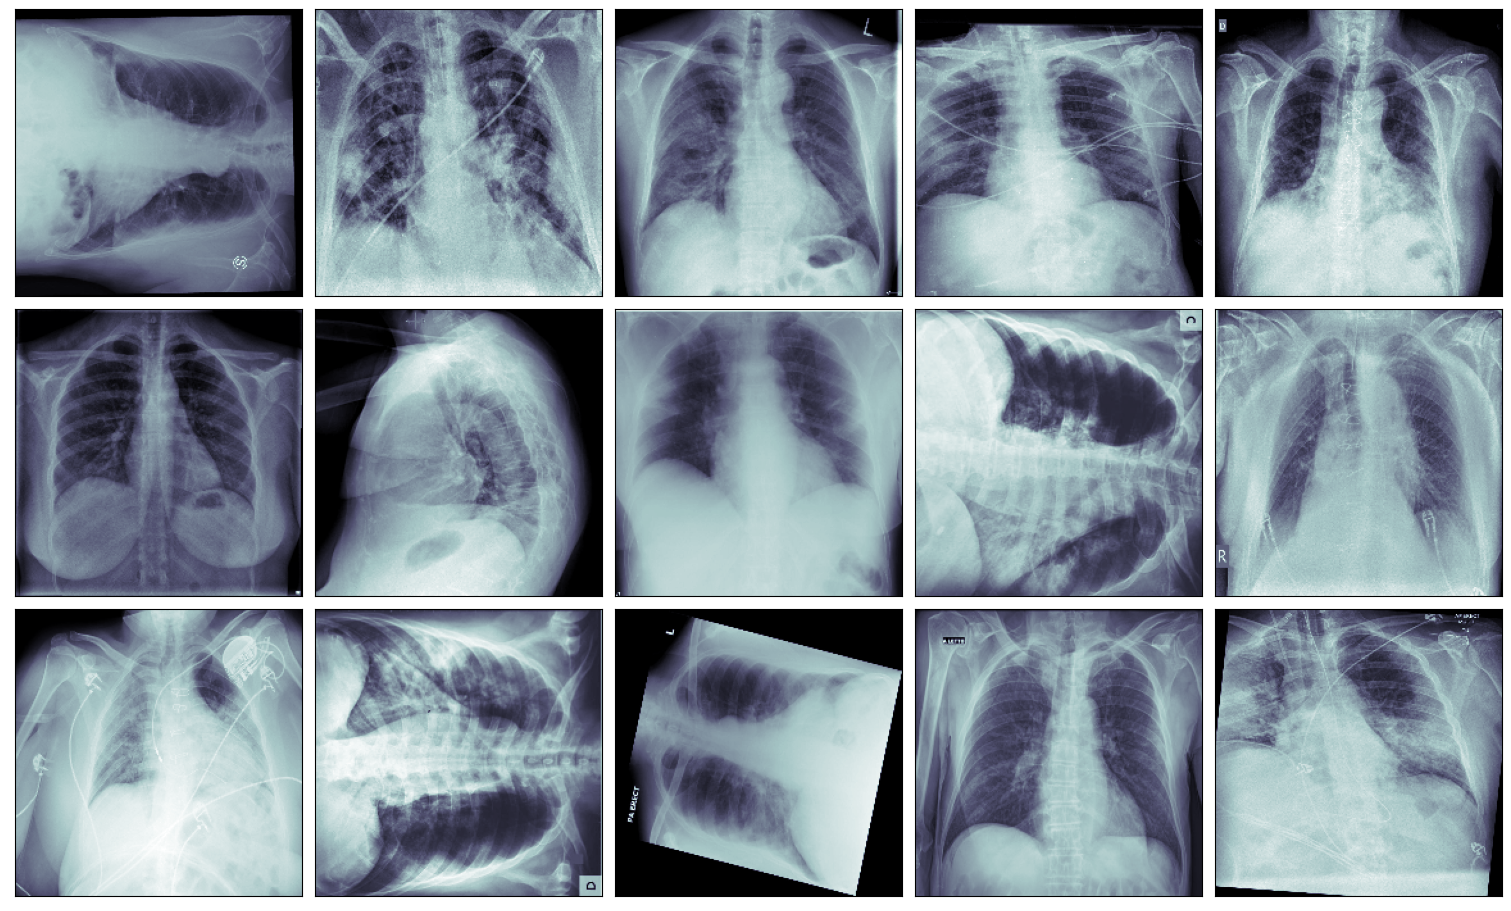

In [7]:
n_row = 3
n_col = 5

fig, ax = plt.subplots(n_row, n_col, figsize = (n_col*3, n_row*3), constrained_layout = True)

for row in tqdm(range(n_row)):
    
    for col in range(n_col):
        
        ax[row][col].imshow(covid[row*n_col + col], cmap = 'bone')
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])

# Data array transfer to numpy array and change shape

In [8]:

data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
target=np.array(target)


new_target=tf.keras.utils.to_categorical(target)
np.save('data',data)
np.save('target',new_target)

print(f"Data shape : {data.shape} \nTarget shape : {target.shape} \nNew Target shape : {new_target.shape}")

Data shape : (30, 224, 224, 1) 
Target shape : (30,) 
New Target shape : (30, 2)


# Model Creation



In [9]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D,Activation,MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras import Input
from tensorflow.keras.callbacks import ModelCheckpoint

input_shape=data.shape[1:] #50,50,1
inp=Input(shape=input_shape)
convs=[]

parrallel_kernels=[3,5,7]

for k in range(len(parrallel_kernels)):
    if(k !=0):
        conv = Conv2D(128, kernel_size = k,padding = 'same' ,activation='relu')(inp)

        convs.append(conv)

out = Concatenate()(convs)
conv_model = Model(inp, out)

model = Sequential()
model.add(conv_model)

# Hidden Layer 2
model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Hidden Layer 3
model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Output layer
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2,input_dim=128,activation='sigmoid'))



Metal device set to: Apple M1 Pro


2022-10-25 15:45:55.441194: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-25 15:45:55.441305: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:

METRICS = [
    'accuracy',
    "sparse_categorical_accuracy",
    'mean_squared_error',
    'mean_absolute_error', 
    'mean_absolute_percentage_error',
    'mean_squared_logarithmic_error',
    'cosine_similarity',
    'logcosh',
]
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=METRICS)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 224, 224, 256)     896       
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 64)      147520    
                                                                 
 activation (Activation)     (None, 222, 222, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)     0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 32)      18464     
                                                                 
 activation_1 (Activation)   (None, 109, 109, 32)      0         
                                                        

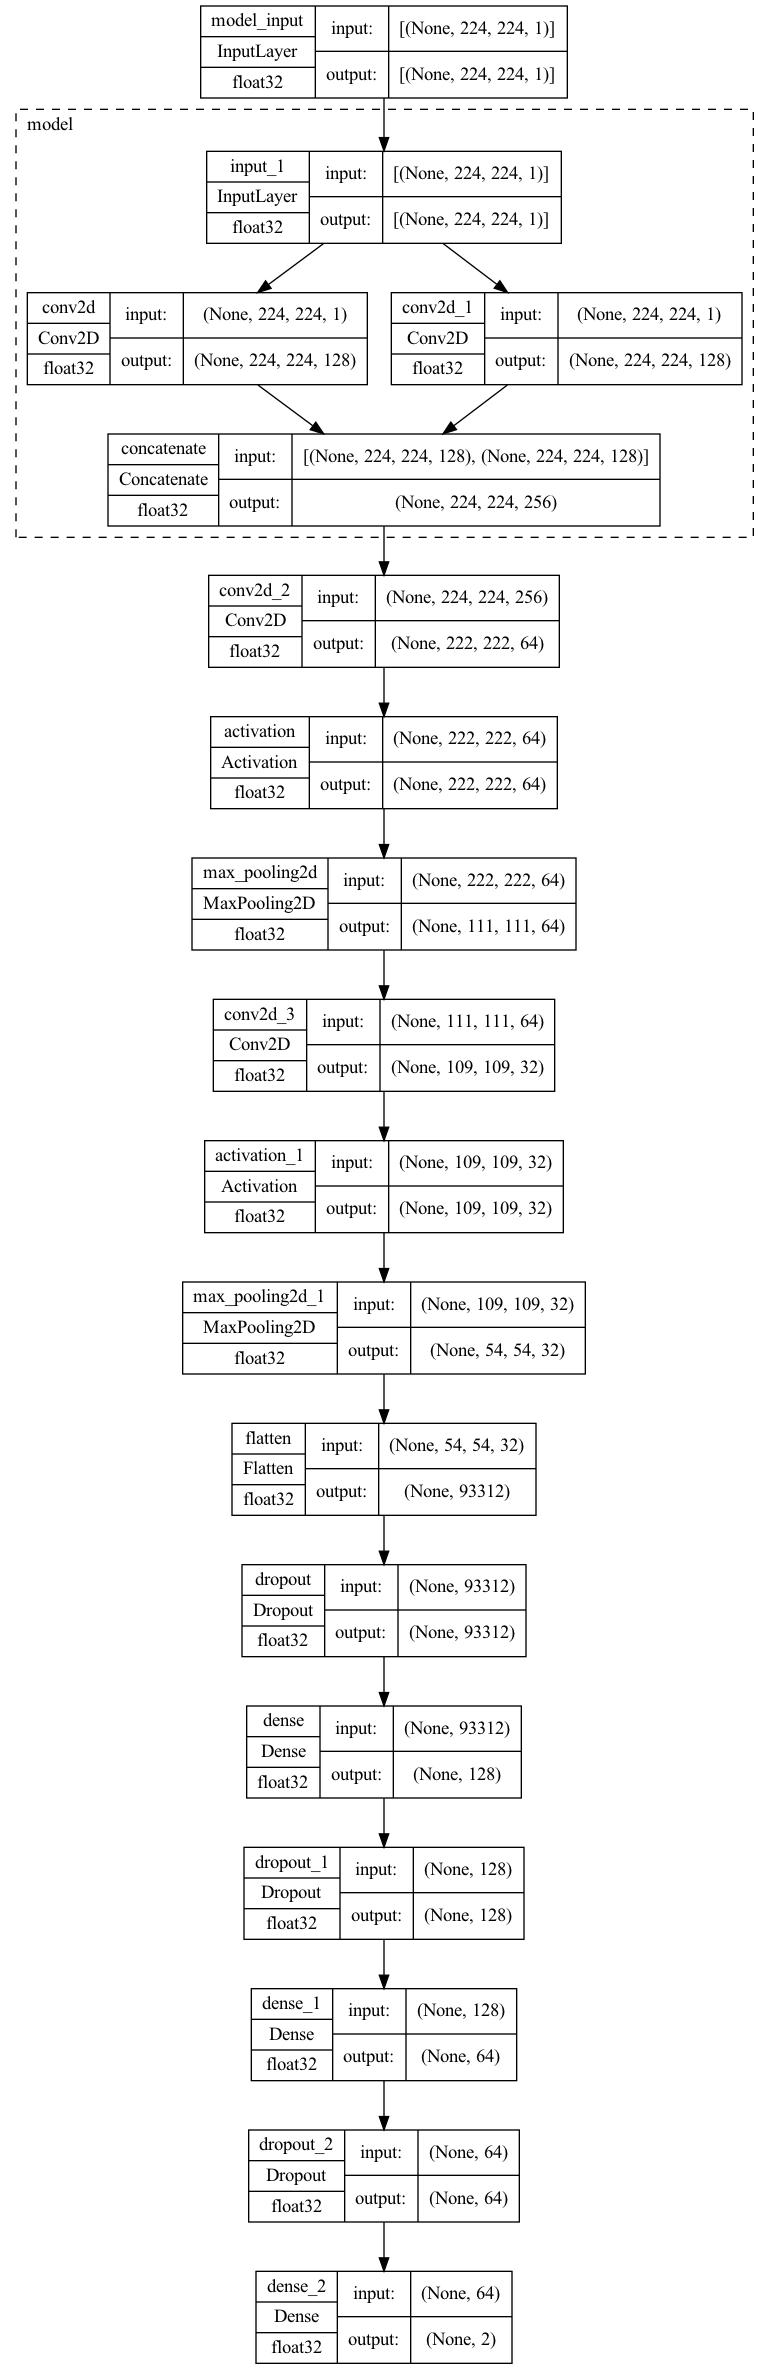

In [12]:
# plot model as image
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
)

In [13]:
from sklearn.model_selection import train_test_split

train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.3)

print(type (train_data))
print(f"Training Data shape : {train_data.shape} \nTraining Target shape : {train_target.shape}")
print(f"Test Data shape : {test_data.shape} \nTest Target shape : {test_target.shape}")

<class 'numpy.ndarray'>
Training Data shape : (21, 224, 224, 1) 
Training Target shape : (21,)
Test Data shape : (9, 224, 224, 1) 
Test Target shape : (9,)


In [14]:
start_time = datetime.datetime.now(tz=timezone)
print(f"Start checkpoint creation:{start_time}")
checkpoint = ModelCheckpoint('model-{epoch:03d}.model',
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')


history=model.fit(train_data,
                  train_target,
                  epochs = 5,
                  batch_size=len(train_data),
                  callbacks=[checkpoint],
                  validation_data = (test_data,test_target))

end_time = datetime.datetime.now(tz=timezone)
print(f"End checkpoint creation:{end_time}")
print(f"Total time taken {end_time-start_time}")

Start checkpoint creation:2022-10-25 15:45:55.885636+05:30
Epoch 1/5


2022-10-25 15:45:55.918998: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-25 15:45:56.207856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 0.6823 - accuracy: 0.5238 - sparse_categorical_accuracy: 0.5238 - mean_squared_error: 0.2492 - mean_absolute_error: 0.4990 - mean_absolute_percentage_error: 285666112.0000 - mean_squared_logarithmic_error: 0.1291 - cosine_similarity: 0.6060 - logcosh: 0.1197

2022-10-25 15:45:57.152941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to model-001.model


INFO:tensorflow:Assets written to: model-001.model/assets


INFO:tensorflow:Assets written to: model-001.model/assets


1/1 [==============================] - 3s 3s/step - loss: 0.6823 - accuracy: 0.5238 - sparse_categorical_accuracy: 0.5238 - mean_squared_error: 0.2492 - mean_absolute_error: 0.4990 - mean_absolute_percentage_error: 285666112.0000 - mean_squared_logarithmic_error: 0.1291 - cosine_similarity: 0.6060 - logcosh: 0.1197 - val_loss: 1.0330 - val_accuracy: 0.3333 - val_sparse_categorical_accuracy: 0.3333 - val_mean_squared_error: 0.2341 - val_mean_absolute_error: 0.4142 - val_mean_absolute_percentage_error: 241565248.0000 - val_mean_squared_logarithmic_error: 0.1160 - val_cosine_similarity: 0.9329 - val_logcosh: 0.1086
Epoch 2/5
1/1 [==============================] - ETA: 0s - loss: 1.5655 - accuracy: 0.4286 - sparse_categorical_accuracy: 0.4286 - mean_squared_error: 0.2801 - mean_absolute_error: 0.4386 - mean_absolute_percentage_error: 322976704.0000 - mean_squared_logarithmic_error: 0.1481 - cosine_similarity: 0.5735 - logcosh: 0.1284
Epoch 2: val_accuracy did not improve from 0.33333
1/1 [

INFO:tensorflow:Assets written to: model-003.model/assets


INFO:tensorflow:Assets written to: model-003.model/assets


1/1 [==============================] - 2s 2s/step - loss: 0.8575 - accuracy: 0.5238 - sparse_categorical_accuracy: 0.5238 - mean_squared_error: 0.3022 - mean_absolute_error: 0.5149 - mean_absolute_percentage_error: 293915648.0000 - mean_squared_logarithmic_error: 0.1522 - cosine_similarity: 0.5797 - logcosh: 0.1416 - val_loss: 0.6901 - val_accuracy: 0.4444 - val_sparse_categorical_accuracy: 0.4444 - val_mean_squared_error: 0.2496 - val_mean_absolute_error: 0.4995 - val_mean_absolute_percentage_error: 166692704.0000 - val_mean_squared_logarithmic_error: 0.1098 - val_cosine_similarity: 0.9428 - val_logcosh: 0.1199
Epoch 4/5
1/1 [==============================] - ETA: 0s - loss: 0.7286 - accuracy: 0.5238 - sparse_categorical_accuracy: 0.5238 - mean_squared_error: 0.2684 - mean_absolute_error: 0.5105 - mean_absolute_percentage_error: 275443328.0000 - mean_squared_logarithmic_error: 0.1352 - cosine_similarity: 0.6005 - logcosh: 0.1280
Epoch 4: val_accuracy did not improve from 0.44444
1/1 [

# Model Save

In [15]:
model.save('model.h5')

In [16]:
#date labeling confusion was removed 

X_train =train_data
Y_train =train_target

x_test =test_data
y_test = test_target


In [17]:
score = model.evaluate(x_test, y_test, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.7790082097053528
Test accuracy: 0.3333333432674408


### What are the containe in history

In [18]:
for k, v in history.history.items():
    print(k)

loss
accuracy
sparse_categorical_accuracy
mean_squared_error
mean_absolute_error
mean_absolute_percentage_error
mean_squared_logarithmic_error
cosine_similarity
logcosh
val_loss
val_accuracy
val_sparse_categorical_accuracy
val_mean_squared_error
val_mean_absolute_error
val_mean_absolute_percentage_error
val_mean_squared_logarithmic_error
val_cosine_similarity
val_logcosh


# Valued to plot in epochs traing's history

## Training and validation accuracy Model

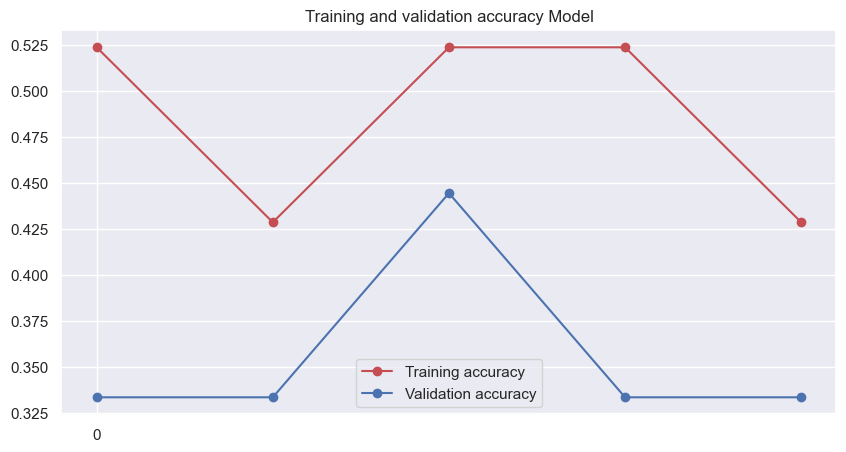

<Figure size 640x480 with 0 Axes>

In [19]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(0,len(acc))
fig = plt.gcf()
fig.set_size_inches(10, 5)

plt.plot(epochs, acc, 'r', label='Training accuracy',marker = "o")
plt.plot(epochs, val_acc, 'b', label='Validation accuracy',marker = "o")
plt.title('Training and validation accuracy Model')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
plt.figure()
plt.show()

## Training and validation Loss Model

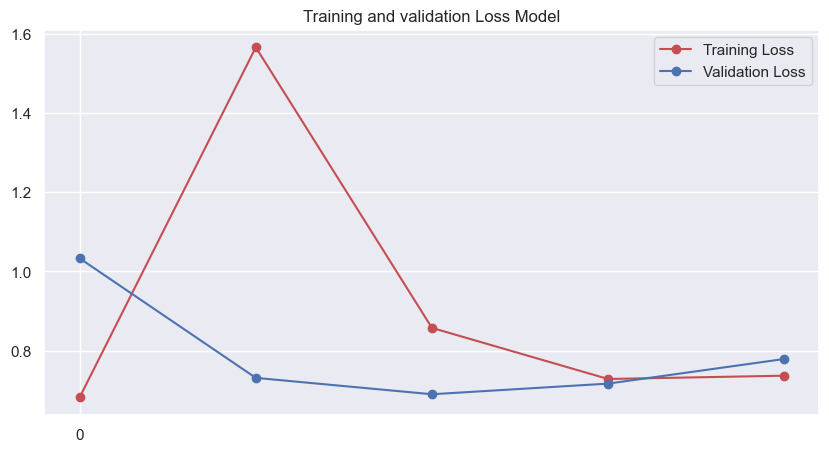

<Figure size 640x480 with 0 Axes>

In [20]:
sns.set()
epochs = range(0, len(acc))
loss = history.history['loss']
val_loss = history.history['val_loss']


fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.plot(epochs, loss, 'r', label='Training Loss', marker="o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss', marker="o")
plt.title('Training and validation Loss Model')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

## Sparse categorical accuracy Model

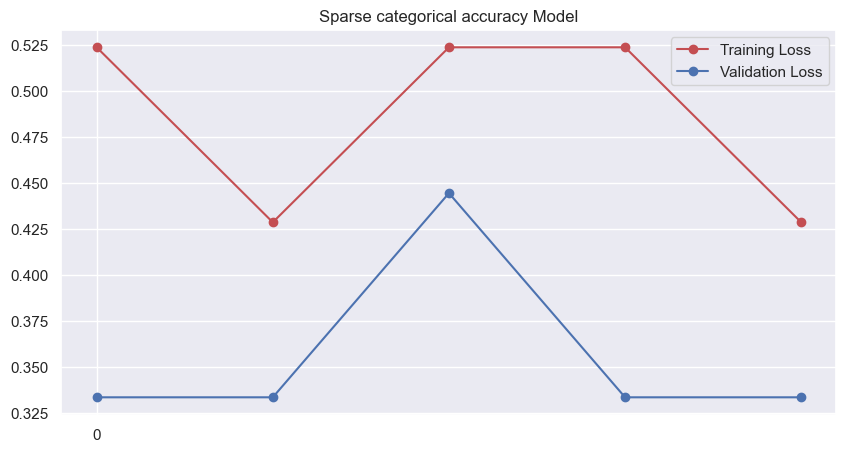

<Figure size 640x480 with 0 Axes>

In [21]:



sns.set()
epochs = range(0,len(acc))
loss = history.history['sparse_categorical_accuracy']
val_loss = history.history['val_sparse_categorical_accuracy']


fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.plot(epochs, loss, 'r', label='Training Loss',marker = "o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss',marker = "o")
plt.title('Sparse categorical accuracy Model')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

## Mean squared error in model

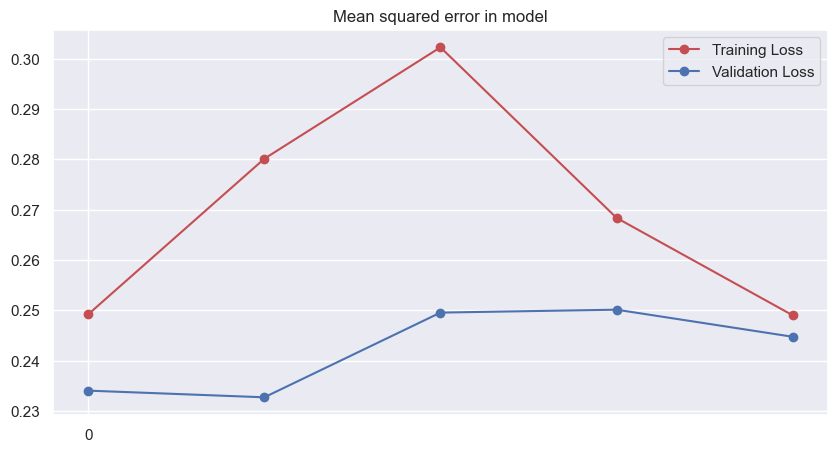

<Figure size 640x480 with 0 Axes>

In [22]:




sns.set()
epochs = range(0,len(acc))
loss = history.history['mean_squared_error']
val_loss = history.history['val_mean_squared_error']


fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.plot(epochs, loss, 'r', label='Training Loss',marker = "o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss',marker = "o")
plt.title('Mean squared error in model')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

## Mean squared absolute error in model

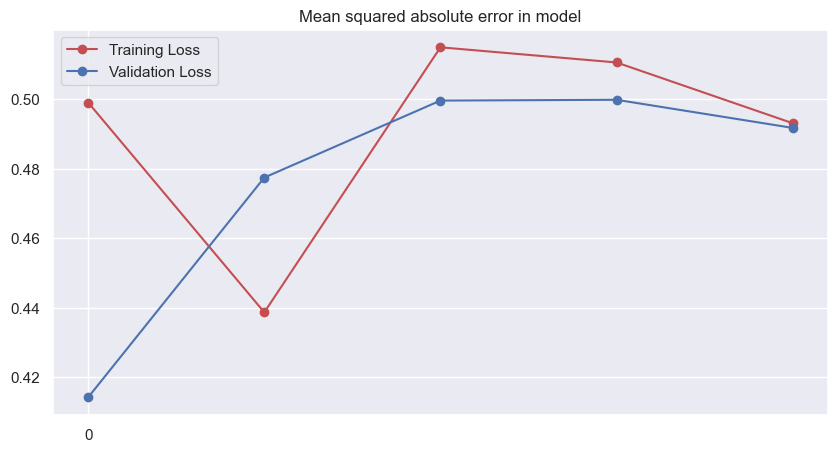

<Figure size 640x480 with 0 Axes>

In [23]:


sns.set()
epochs = range(0,len(acc))
loss = history.history['mean_absolute_error']
val_loss = history.history['val_mean_absolute_error']


fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.plot(epochs, loss, 'r', label='Training Loss',marker = "o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss',marker = "o")
plt.title('Mean squared absolute error in model')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

## Mean absolute percentage error in model

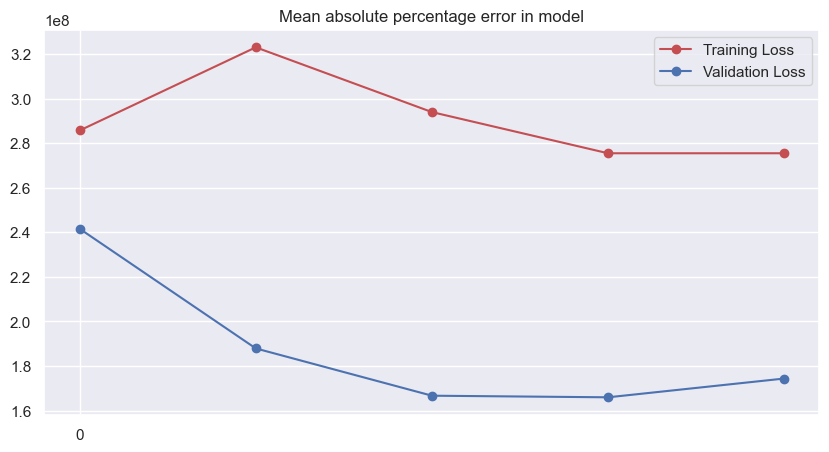

<Figure size 640x480 with 0 Axes>

In [24]:

sns.set()
epochs = range(0,len(acc))
loss = history.history['mean_absolute_percentage_error']
val_loss = history.history['val_mean_absolute_percentage_error']


fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.plot(epochs, loss, 'r', label='Training Loss',marker = "o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss',marker = "o")
plt.title('Mean absolute percentage error in model')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

## Mean squared logarithmic error in model

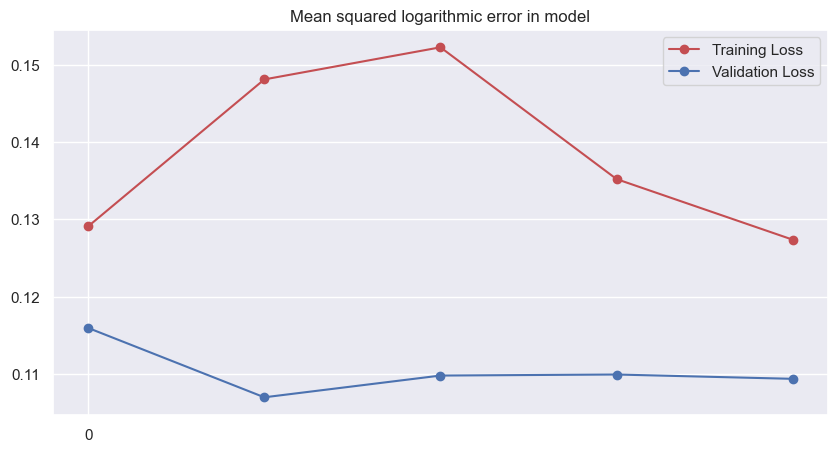

<Figure size 640x480 with 0 Axes>

In [25]:


sns.set()
epochs = range(0,len(acc))
loss = history.history['mean_squared_logarithmic_error']
val_loss = history.history['val_mean_squared_logarithmic_error']


fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.plot(epochs, loss, 'r', label='Training Loss',marker = "o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss',marker = "o")
plt.title('Mean squared logarithmic error in model')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

In [26]:
## Cosine similarity in model

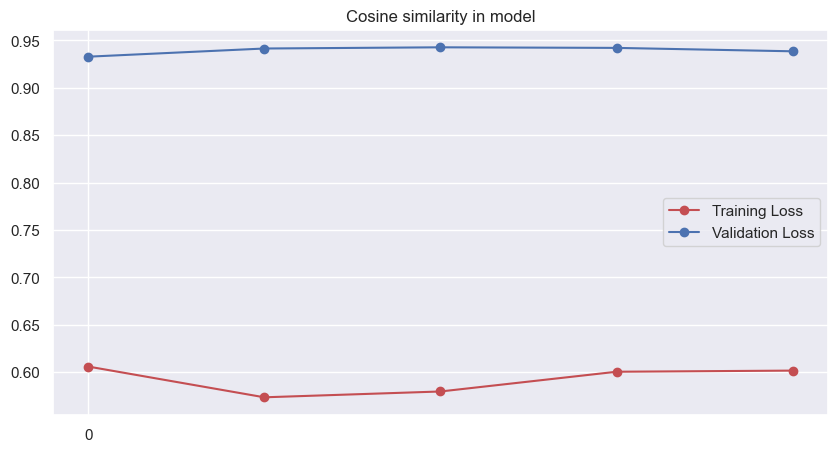

<Figure size 640x480 with 0 Axes>

In [27]:

sns.set()
epochs = range(0,len(acc))
loss = history.history['cosine_similarity']
val_loss = history.history['val_cosine_similarity']


fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.plot(epochs, loss, 'r', label='Training Loss',marker = "o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss',marker = "o")
plt.title('Cosine similarity in model')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

## Log-Cosh Loss

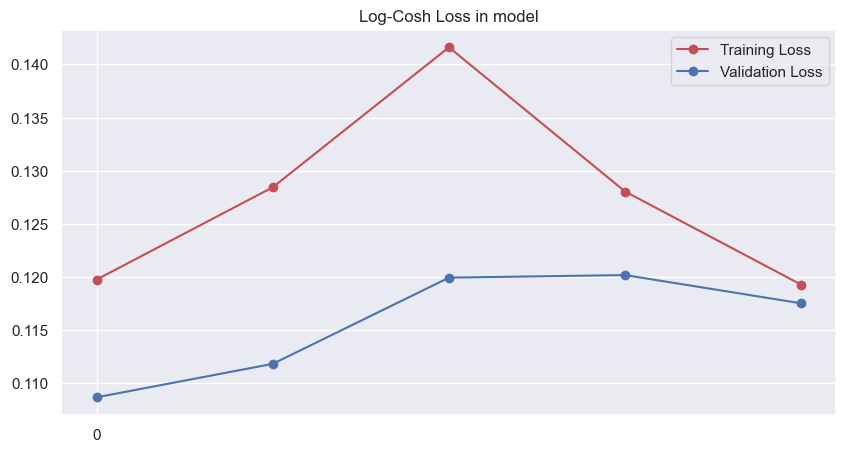

<Figure size 640x480 with 0 Axes>

In [28]:

sns.set()
epochs = range(0,len(acc))
loss = history.history['logcosh']
val_loss = history.history['val_logcosh']


fig = plt.gcf()
fig.set_size_inches(10, 5)
plt.plot(epochs, loss, 'r', label='Training Loss',marker = "o")
plt.plot(epochs, val_loss, 'b', label='Validation Loss',marker = "o")
plt.title('Log-Cosh Loss in model')
plt.xticks(np.arange(0, len(acc), 10))
plt.legend(loc=0)
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

## History validation and loss in one plot

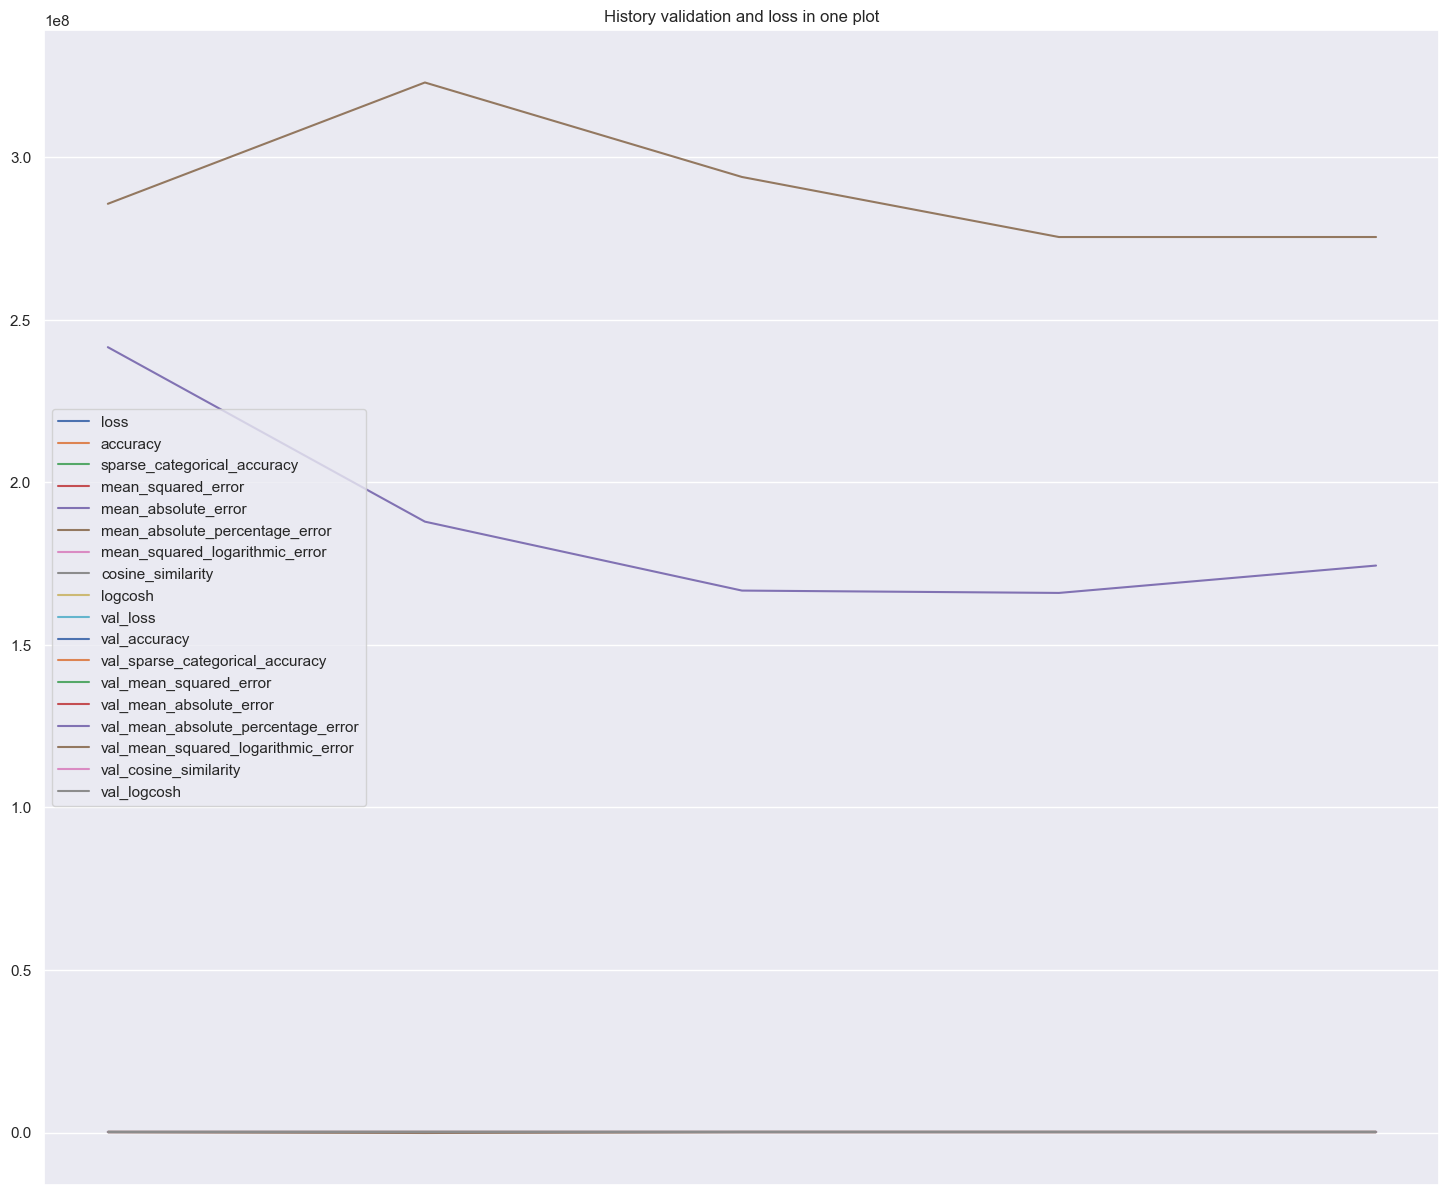

<Figure size 640x480 with 0 Axes>

In [29]:
pd.DataFrame(history.history).plot(figsize=(18,15))

plt.title('History validation and loss in one plot')
plt.legend(loc=0)
plt.xticks(np.arange(0, 0, 10))
#plt.savefig('Multiclass Model .png')
plt.figure()
plt.show()

# Model Evaluation Results

## Confution Matrix

1/1 [==============================] - 0s 83ms/step


2022-10-25 15:46:04.239534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


<Figure size 1000x500 with 0 Axes>

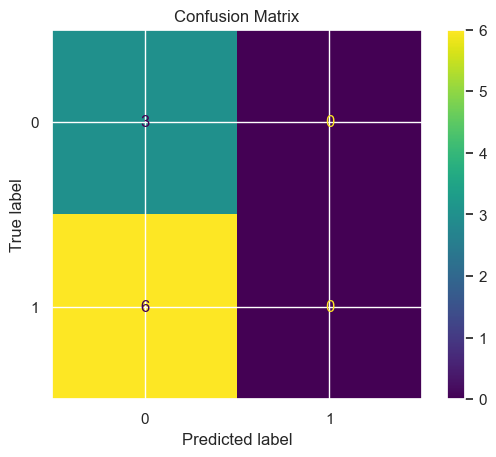

<Figure size 640x480 with 0 Axes>

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

fig = plt.gcf()
fig.set_size_inches(10, 5)

clf = model
pred = model.predict(x_test)[:, 1]
# print(pred)
predictions = (pred > 0.5).astype(int)
# print(predictions)
# print(y_test)
cm = confusion_matrix(y_test, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.figure()
plt.show()

In [31]:
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print(tn, fp, fn, tp)

3 0 6 0


## Sensitivity / True Positive Rate

In [32]:
# Sensitivity = True Positives/ (True Positives + True Negatives)
sensitivity = tp / (tp + tn)
print(f"Sensitivity : {sensitivity}")

Sensitivity : 0.0


## Specificity / True Negative Rate:

In [33]:
# Specificity = True Negatives/ (False Positives + True Negatives)
specificity = tn / (fp+tn)
print(f"Specificity : {specificity}")

Specificity : 1.0


## ROC AUC Score

In [34]:
from sklearn.metrics import roc_auc_score
score = roc_auc_score(y_test, predictions)
print(f"ROC AUC: {score:.4f}")

ROC AUC: 0.5000


## ROC Curve

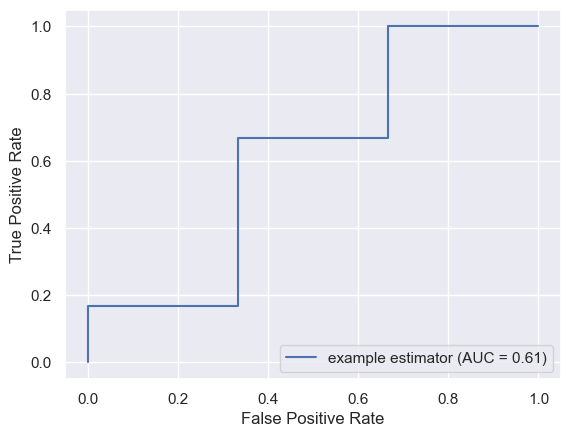

In [35]:
import matplotlib.pyplot as plt

from sklearn import metrics


fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()

plt.show()

##  Classification Report

              precision    recall  f1-score   support

           0       0.33      1.00      0.50         3
           1       0.00      0.00      0.00         6

    accuracy                           0.33         9
   macro avg       0.17      0.50      0.25         9
weighted avg       0.11      0.33      0.17         9



/Users/lalithk90/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lalithk90/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lalithk90/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

<AxesSubplot: >

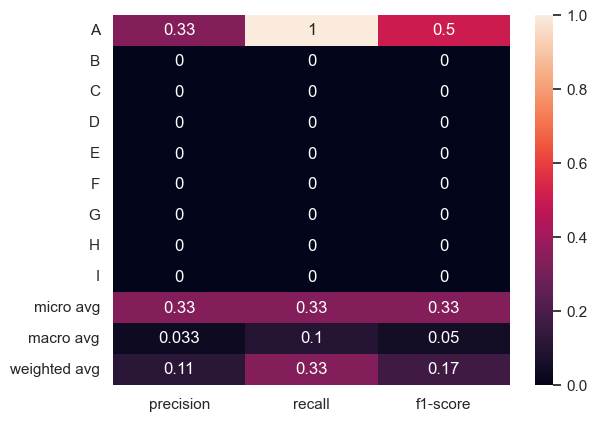

In [36]:
from sklearn.metrics import classification_report
import seaborn as sns
target_names = list("ABCDEFGHI")
labels = np.arange(10)

classification_report_1 = classification_report(y_test, predictions)
print(classification_report_1)
classification_report = classification_report(y_test, predictions,labels=labels,
                                   target_names=target_names,
                                   output_dict=True)

sns.heatmap(pd.DataFrame(classification_report).iloc[:-1, :].T, annot=True)


## Accuracy Score

In [37]:
from sklearn.metrics import accuracy_score
y_pred = predictions
y_true = y_test

ac_s_without_normalize = accuracy_score(y_true, y_pred)
print(f"Accuracy score without normalize : {ac_s_without_normalize}")

ac_s_with_normalize =accuracy_score(y_true, y_pred, normalize=False)
print(f"Accuracy score with normalize: {ac_s_with_normalize}")

Accuracy score without normalize : 0.3333333333333333
Accuracy score with normalize: 3


## Balance Accuracy Score

In [38]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score=balanced_accuracy_score(y_true, y_pred)
print(f"Balanced accuracy score : {balanced_accuracy_score}")

Balanced accuracy score : 0.5


## Average precision score

In [39]:
from sklearn.metrics import average_precision_score
average_precision_score = average_precision_score(y_true, y_pred)
print(f"Average precision score : {average_precision_score}")

Average precision score : 0.6666666666666666


## Precision Score

Precision score macro : 0.16666666666666666
Precision score micro : 0.3333333333333333
Precision score weighted : 0.1111111111111111
Precision score : [0.33333333 0.        ]


/Users/lalithk90/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lalithk90/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lalithk90/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

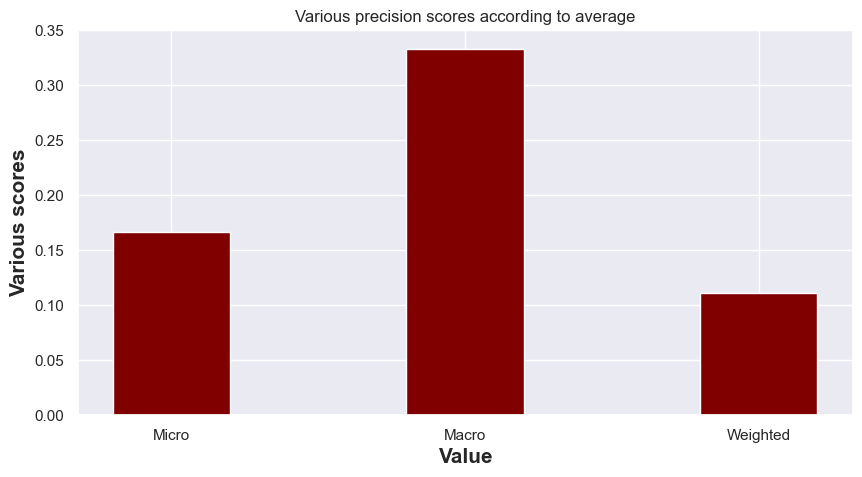

In [40]:
from sklearn.metrics import precision_score

precision_score_macro = precision_score(y_true, y_pred, average='macro')

precision_score_micro = precision_score(y_true, y_pred, average='micro')

precision_score_weighted = precision_score(y_true, y_pred, average='weighted')

precision_score = precision_score(y_true, y_pred, average=None)

print(f"Precision score macro : {precision_score_macro}")
print(f"Precision score micro : {precision_score_micro}")
print(f"Precision score weighted : {precision_score_weighted}")
print(f"Precision score : {precision_score}")


data = {'Micro':precision_score_macro, 'Macro':precision_score_micro, 'Weighted':precision_score_weighted}
values = list(data.keys())
results = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(values, results, color ='maroon',
        width = 0.4)
 
plt.xlabel('Value', fontweight ='bold', fontsize = 15)
plt.ylabel('Various scores', fontweight ='bold', fontsize = 15)
plt.title("Various precision scores according to average")
plt.show()


## Recall Score

Recall score macro : 0.5
Recall score micro : 0.3333333333333333
Recall score weighted : 0.3333333333333333
Recall score : [1. 0.]


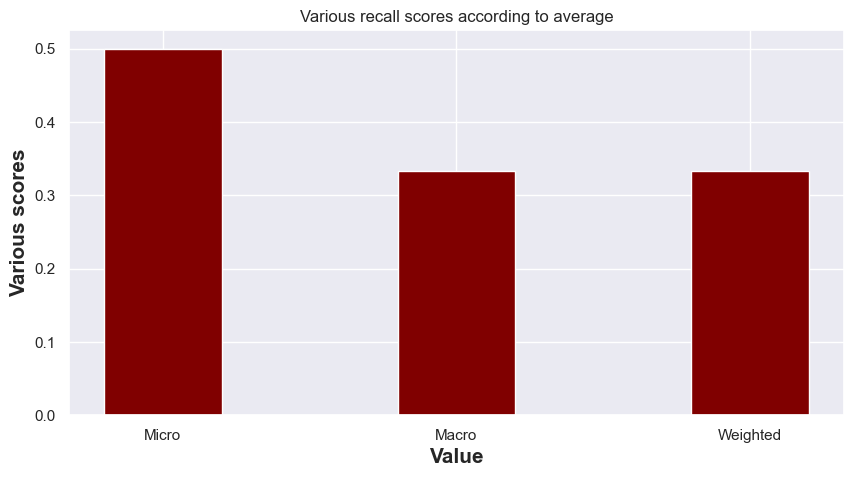

In [41]:
from sklearn.metrics import recall_score

recall_score_macro =recall_score(y_true, y_pred, average='macro')

recall_score_micro =recall_score(y_true, y_pred, average='micro')

recall_score_weighted =recall_score(y_true, y_pred, average='weighted')

recall_score =recall_score(y_true, y_pred, average=None)


print(f"Recall score macro : {recall_score_macro}")
print(f"Recall score micro : {recall_score_micro}")
print(f"Recall score weighted : {recall_score_weighted}")
print(f"Recall score : {recall_score}")

data = {'Micro':recall_score_macro, 'Macro':recall_score_micro, 'Weighted':recall_score_weighted}
values = list(data.keys())
results = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(values, results, color ='maroon',
        width = 0.4)
 
plt.xlabel('Value', fontweight ='bold', fontsize = 15)
plt.ylabel('Various scores', fontweight ='bold', fontsize = 15)
plt.title("Various recall scores according to average")
plt.show()

## F1 Score

Recall score macro : 0.25
Recall score micro : 0.3333333333333333
Recall score weighted : 0.16666666666666666
Recall score : [0.5 0. ]


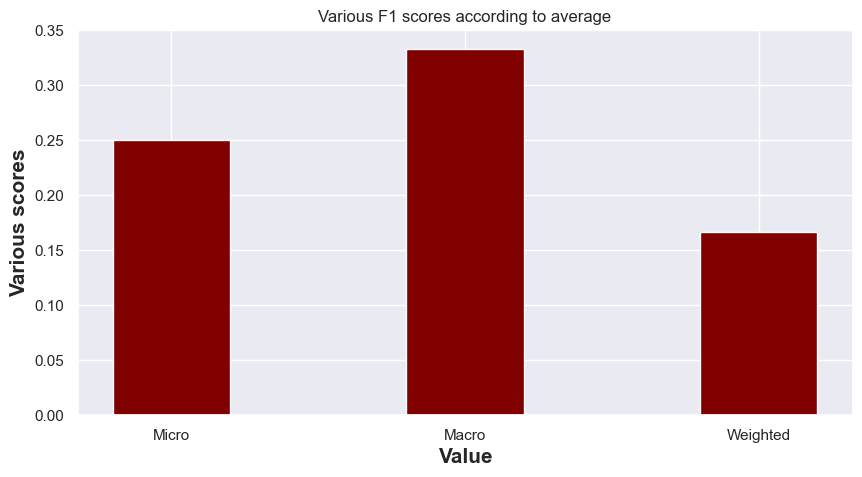

In [42]:
from sklearn.metrics import f1_score

f1_score_macro=f1_score(y_true, y_pred, average='macro')

f1_score_micro=f1_score(y_true, y_pred, average='micro')

f1_score_weighted=f1_score(y_true, y_pred, average='weighted')

f1_score=f1_score(y_true, y_pred, average=None)

print(f"Recall score macro : {f1_score_macro}")
print(f"Recall score micro : {f1_score_micro}")
print(f"Recall score weighted : {f1_score_weighted}")
print(f"Recall score : {f1_score}")

data = {'Micro':f1_score_macro, 'Macro':f1_score_micro, 'Weighted':f1_score_weighted}
values = list(data.keys())
results = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(values, results, color ='maroon',
        width = 0.4)
 
plt.xlabel('Value', fontweight ='bold', fontsize = 15)
plt.ylabel('Various scores', fontweight ='bold', fontsize = 15)
plt.title("Various F1 scores according to average")
plt.show()

## Binary accuracy

In [43]:
m = tf.keras.metrics.binary_accuracy(y_true, y_pred)
print(f"Binary accuracy: {m}")


Binary accuracy: 0.3333333432674408


## Categorical accuracy

In [44]:
m = tf.keras.metrics.categorical_accuracy(y_true, y_pred)
print(f"Categorical accuracy: {m}")



Categorical accuracy: 1.0


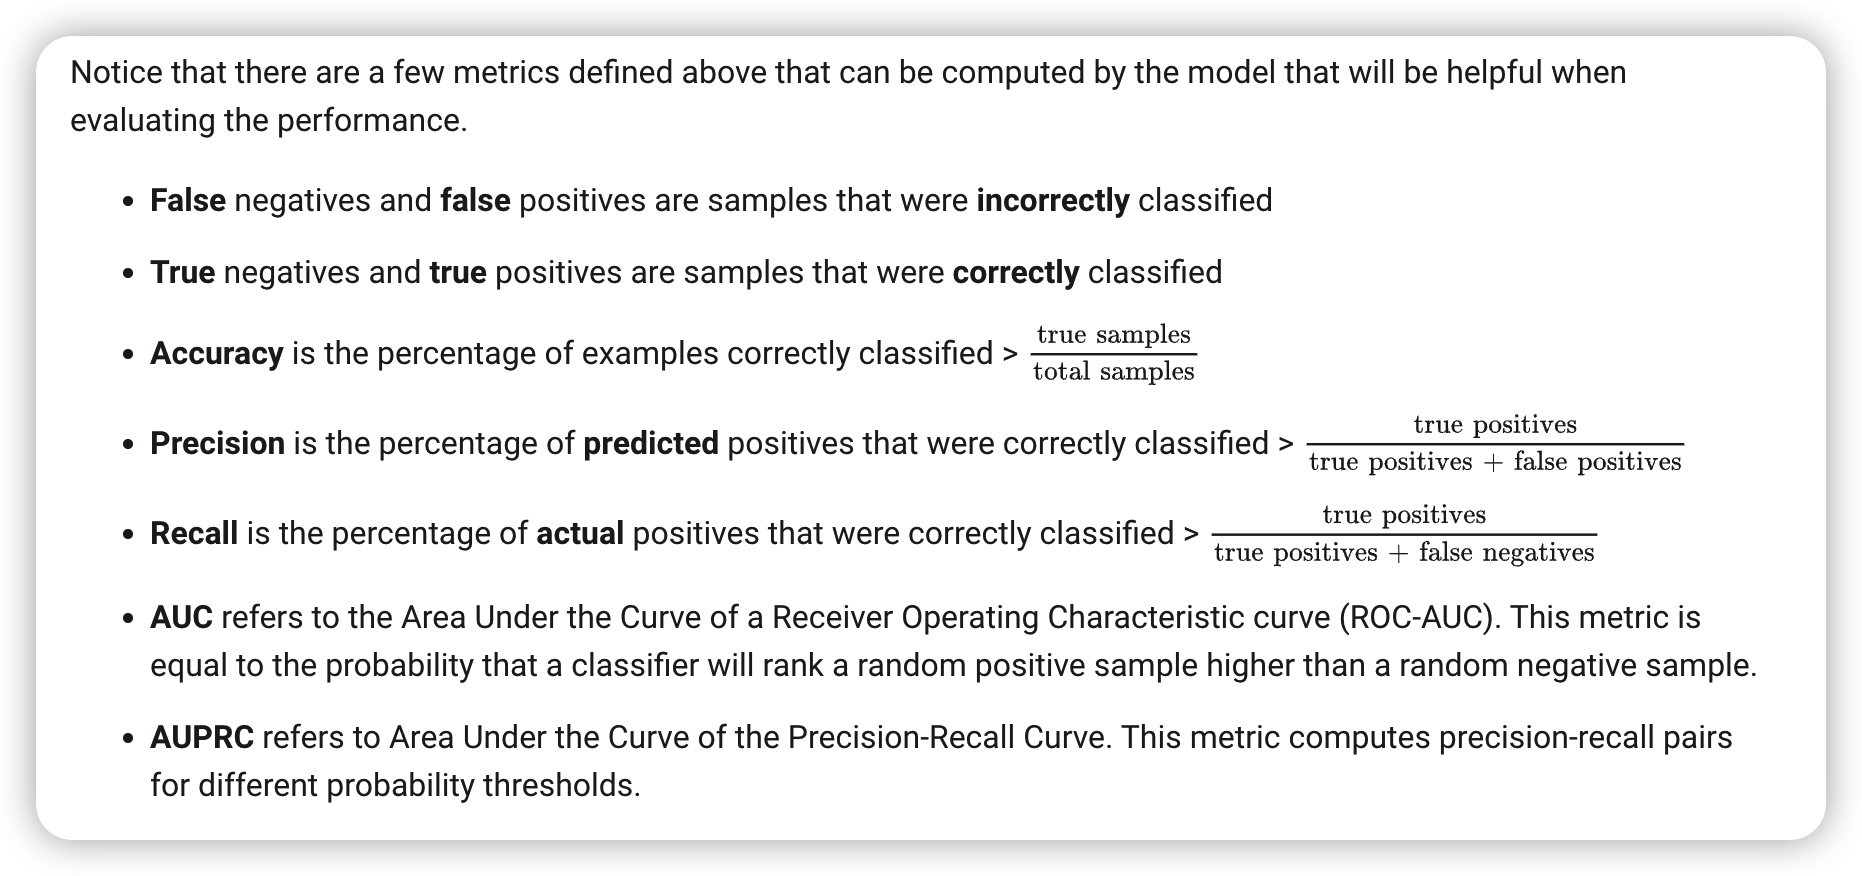

